# Data preparation for testing

The cell below is used to create a Golden Standard csv file, by reading the 'tagged_dataset.json.  Used to check if the model's NER prediction is correct.

Format:
| FILE_PATH                                               | LESSOR_NAME      | LESSEE_NAME      | PROPERTY_ADDRESS                                 | LEASE_START_DATE | LEASE_END_DATE   | RENT_AMOUNT | SECURITY_DEPOSIT_AMOUNT |
|----------------------------------------------------------|------------------|------------------|--------------------------------------------------|------------------|------------------|-------------|--------------------------|
| ./datasets/dataset-master/Lease_Agreement_1.docx   | Ashley Martinez  | Sarah Williams   | 5316 Pine Rd, Franklin, CA 70457                 | May 26, 2025     | May 26, 2026     | $1038       |  $1245                    |
| ./datasets/dataset-master/Lease_Agreement_2.docx  | Ashley Jones     | Jessica Miller   | 538 Spruce Ct, Springfield, NY 82660             | December 16, 2024| December 16, 2025| $1746       |  $2095                    |
| ./datasets/dataset-master/Lease_Agreement_3.docx   | Brian Miller     | Amanda Garcia    | 1807 Chestnut Blvd, Fairview, CA 68967           | September 20, 2024| September 20, 2025| $2611     |  $3133                    |
| ./datasets/dataset-master/Lease_Agreement_4.docx   | David Hernandez  | Michael Johnson  | 2658 Elm St, Franklin, GA 71686                  | May 28, 2025     | May 28, 2026     | $3330       |  $3996                   |


In [2]:
from docx import Document
import pandas as pd

dataframe = pd.DataFrame(columns=['FILE_PATH', 'LESSOR_NAME', 'LESSEE_NAME', 'PROPERTY_ADDRESS', 'LEASE_START_DATE', 'LEASE_END_DATE', 'RENT_AMOUNT', 'SECURITY_DEPOSIT_AMOUNT'])

def data_preprocessing(data):
    for f in data:
        file_name = f["file_path"]
        doc_path = file_name
        doc = Document(doc_path)
        text = "\n".join([p.text for p in doc.paragraphs if p.text.strip()]).strip()

        # Tokenize by whitespace, and track char positions
        tokens = []
        token_spans = []
        start = 0
        for word in text.split():
            start = text.find(word, start)  # Find next occurrence
            end = start + len(word)
            tokens.append(word)
            token_spans.append((start, end))
            start = end

        # Initialize all labels to 0 ("O")
        labels = [0] * len(tokens)
        row =[file_name]
        # Map character spans to token indices
        for entity_name, span in f["entities"].items():
            ent_start = span["start"]
            ent_end = span["end"]
            row.append(text[ent_start:ent_end])
        dataframe.loc[len(dataframe)] = row

    # Save to CSV
    dataframe.to_csv("golden_data.csv", index=False)





In [3]:
import json

file_path = "datasets/tagged_testing_dataset.json"

with open(file_path) as f:
    data = json.load(f)
    data_preprocessing(data)

### exact_match_results(pred_file, golden_file, result_file='./result.csv')

**Parameters:**

- `pred_file`: Path to the **prediction result CSV file**
- `golden_file`: Path to the **golden standard (ground truth) CSV file**
- `result_file`: Path to save the output result CSV. Defaults to `'./result.csv'`.

---

**What it does:**

1. Loads both CSVs into Pandas DataFrames.
2. Iterates through each row in `pred_file`.
3. Matches the corresponding row in `golden_file` using the `FILE_PATH` column.
4. Compares each field defined in the evaluation (e.g., `LESSOR_NAME`, `LEASE_START_DATE`, etc.).
5. For each field:
   - Appends `1` if the prediction **exactly matches** the golden truth.
   - Appends `0` if it **does not match**.
6. Appends the comparison results as a new row into the result DataFrame.
7. Saves the result DataFrame to `result_file` in CSV format.

---

**Output:**

A CSV file where each row contains binary (1/0) match scores for each entity field, representing **exact match accuracy** per field per document.

| FILE_PATH                       | LESSOR_NAME | LESSEE_NAME | ... |
|--------------------------------|-------------|-------------|-----|
| Lease_Agreement_Test3.docx     | 1           | 0           | ... |
| Lease_Agreement_Test4.docx     | 1           | 1           | ... |

---

**Use case:**

Best suited for evaluating **NER predictions** when **strict exact match evaluation** is required for each entity.


In [4]:
import pandas as pd

def exact_match_results(pred_file, golden_file, result_file='result.csv'):
    # Load prediction and original CSVs
    pred_df = pd.read_csv(pred_file)
    orig_df = pd.read_csv(golden_file)

    # Columns to compare
    columns = [
        'LESSOR_NAME', 'LESSEE_NAME', 'PROPERTY_ADDRESS',
        'LEASE_START_DATE', 'LEASE_END_DATE',
        'RENT_AMOUNT', 'SECURITY_DEPOSIT_AMOUNT'
    ]

    # Initialize the result DataFrame
    result_dataframe = pd.DataFrame(columns=['FILE_PATH'] + columns)

    # Iterate through prediction file
    for i in range(len(pred_df)):
        file_path = pred_df.iloc[i].get('FILE_PATH')
        orig = orig_df[orig_df['FILE_PATH'] == file_path]

        # Skip if no match in original
        if orig.empty:
            continue

        pred_row = pred_df[pred_df['FILE_PATH'] == file_path].iloc[0]
        orig_row = orig.iloc[0]

        comparison = {'FILE_PATH': file_path}

        for col in columns:
            if col in pred_row and col in orig_row:
                comparison[col] = int(str(pred_row[col]).strip() == str(orig_row[col]).strip())
            else:
                comparison[col] = ""  # or use 0, None, np.nan

        result_dataframe = pd.concat([result_dataframe, pd.DataFrame([comparison])], ignore_index=True)

    # Save to CSV
    result_dataframe.to_csv(result_file, index=False)


### partial_match_results(pred_file, golden_file, result_file='partial_result.csv')

**Parameters:**

- `pred_file`: Path to the **prediction result CSV file**
- `golden_file`: Path to the **ground truth (golden standard) CSV file**
- `result_file`: Path to save the output CSV. Defaults to `'partial_result.csv'`.

---

**What it does:**

1. Loads both CSV files into Pandas DataFrames.
2. Iterates through each row in the `pred_file`.
3. Matches the row in `golden_file` based on the `FILE_PATH` column.
4. For each entity field (e.g., `LESSOR_NAME`, `PROPERTY_ADDRESS`):
   - Applies **fuzzy string matching** using `fuzz.token_sort_ratio`.
   - Assigns a partial credit score based on match closeness:
     - `1.0` if score ≥ 95
     - `0.75` if score ≥ 85
     - `0.5` if score ≥ 70
     - `0.25` if score ≥ 50
     - `0.0` otherwise or if missing
5. Builds a result DataFrame with per-field fuzzy match scores.
6. Saves the output DataFrame to a CSV file at `result_file`.

---

**Output:**
A CSV file where each row represents a lease document, and each column represents a field's **partial match score** between prediction and ground truth.

| FILE_PATH                       | LESSOR_NAME | LESSEE_NAME | ... |
|--------------------------------|-------------|-------------|-----|
| Lease_Agreement_Test10.docx    | 1.0         | 0.75        | ... |

---

**Use case:**
Useful for evaluating **Named Entity Recognition (NER)** outputs where predictions may not be exact matches but are **close enough** semantically or structurally.


In [5]:
import pandas as pd
from fuzzywuzzy import fuzz

def partial_match_results(pred_file, golden_file, result_file='partial_result.csv'):
    pred_df = pd.read_csv(pred_file)
    orig_df = pd.read_csv(golden_file)

    columns = [
        'LESSOR_NAME', 'LESSEE_NAME', 'PROPERTY_ADDRESS',
        'LEASE_START_DATE', 'LEASE_END_DATE',
        'RENT_AMOUNT', 'SECURITY_DEPOSIT_AMOUNT'
    ]

    result_dataframe = pd.DataFrame(columns=['FILE_PATH'] + columns)

    def fuzzy_score(pred, gold):
        if pd.isna(pred) or pd.isna(gold):
            return 0.0
        pred = str(pred).strip()
        gold = str(gold).strip()
        score = fuzz.token_sort_ratio(pred, gold)
        if score >= 95:
            return 1.0
        elif score >= 85:
            return 0.75
        elif score >= 70:
            return 0.5
        elif score >= 50:
            return 0.25
        else:
            return 0.0

    for i in range(len(pred_df)):
        file_path = pred_df.iloc[i].get('FILE_PATH')
        orig = orig_df[orig_df['FILE_PATH'] == file_path]

        if orig.empty:
            continue

        pred_row = pred_df[pred_df['FILE_PATH'] == file_path].iloc[0]
        orig_row = orig.iloc[0]

        comparison = {'FILE_PATH': file_path}
        for col in columns:
            if col in pred_row and col in orig_row:
                comparison[col] = fuzzy_score(pred_row[col], orig_row[col])
            else:
                comparison[col] = ""  # or use 0.0 or None depending on your needs

        result_dataframe = pd.concat([result_dataframe, pd.DataFrame([comparison])], ignore_index=True)

    result_dataframe.to_csv(result_file, index=False)


D:\NEU\Summer2025\NLP\Assignments\.venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### evaluate_result_csv(result_file, threshold)

This function calculates evaluation metrics (Precision, Recall, F1) from a CSV file containing predicted NER results (e.g., fuzzy scores).

#### Key Steps:

1. Loads the prediction CSV using pandas
2. Drops the `FILE_PATH` column if present
3. For each entity column:
   - Treats scores ≥ `threshold` as true positives
   - Calculates:
     - **Precision** = TP / Total predicted
     - **Recall** = TP / Total gold labels
     - **F1 Score** = Harmonic mean of precision and recall
4. Returns a dictionary of metrics per entity

Set `threshold=1.0` for exact-match evaluation, or lower for partial match scoring.


In [6]:
def evaluate_result_csv(result_file, threshold=0.5):
    df = pd.read_csv(result_file)

    if 'FILE_PATH' in df.columns:
        df = df.drop(columns=['FILE_PATH'])

    metrics = {}

    for col in df.columns:
        values = df[col].fillna(0).astype(float)

        tp = (values >= threshold).sum()
        total_pred = len(values)
        total_gold = len(values)  # assumes gold data is one row per file

        precision = tp / total_pred if total_pred else 0
        recall = tp / total_gold if total_gold else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        metrics[col] = {
            'total': total_pred,
            'true_positives': int(tp),
            'precision': round(precision, 3),
            'recall': round(recall, 3),
            'f1_score': round(f1, 3)
        }

    return metrics


In [7]:
bert_exact = evaluate_result_csv("legalBert/bert_exact_result.csv", 1.0)
with open("legalBert/bert_exact.json", "w", encoding="utf-8") as f:
    json.dump(bert_exact, f, indent=4, ensure_ascii=False)

bert_partial = evaluate_result_csv("legalBert/bert_partial_result.csv")
with open("legalBert/bert_partial.json", "w", encoding="utf-8") as f:
    json.dump(bert_partial, f, indent=4, ensure_ascii=False)

In [8]:
exact_match_results('spacy_legalBert/spacy_bert_result.csv', 'datasets/golden_data.csv',
                    'spacy_legalBert/spacy_bert_exact_result.csv')
partial_match_results('spacy_legalBert/spacy_bert_result.csv', 'datasets/golden_data.csv',
                      'spacy_legalBert/spacy_bert_partial_result.csv')

C:\Users\Vaishali\AppData\Local\Temp\ipykernel_17436\3153390376.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_dataframe = pd.concat([result_dataframe, pd.DataFrame([comparison])], ignore_index=True)


In [9]:
spacy_bert_exact = evaluate_result_csv("spacy_legalBert/spacy_bert_exact_result.csv", 1.0)
with open("spacy_legalBert/spacy_bert_exact.json", "w", encoding="utf-8") as f:
    json.dump(spacy_bert_exact, f, indent=4, ensure_ascii=False)

spacy_bert = evaluate_result_csv("spacy_legalBert/spacy_bert_partial_result.csv")
with open("spacy_legalBert/spacy_bert_partial.json", "w", encoding="utf-8") as f:
    json.dump(spacy_bert, f, indent=4, ensure_ascii=False)

## Plotting findings


F1 Score Data:
                          spaCy (Exact)  spaCy (Partial)  LegalBERT (Exact)  \
LESSOR_NAME                      0.762            0.571                0.0   
LESSEE_NAME                      0.762            0.786                0.0   
PROPERTY_ADDRESS                 0.476            0.357                0.0   
LEASE_START_DATE                 0.095            0.000                0.0   
LEASE_END_DATE                   1.000            1.000                0.0   
SECURITY_DEPOSIT_AMOUNT          0.714            0.857                0.0   
RENT_AMOUNT                      0.000            0.000                0.0   

                         LegalBERT (Partial)  spaCy+LegalBERT (Exact)  \
LESSOR_NAME                            0.929                    0.667   
LESSEE_NAME                            0.929                    0.667   
PROPERTY_ADDRESS                       0.643                    0.048   
LEASE_START_DATE                       0.357                    0.1

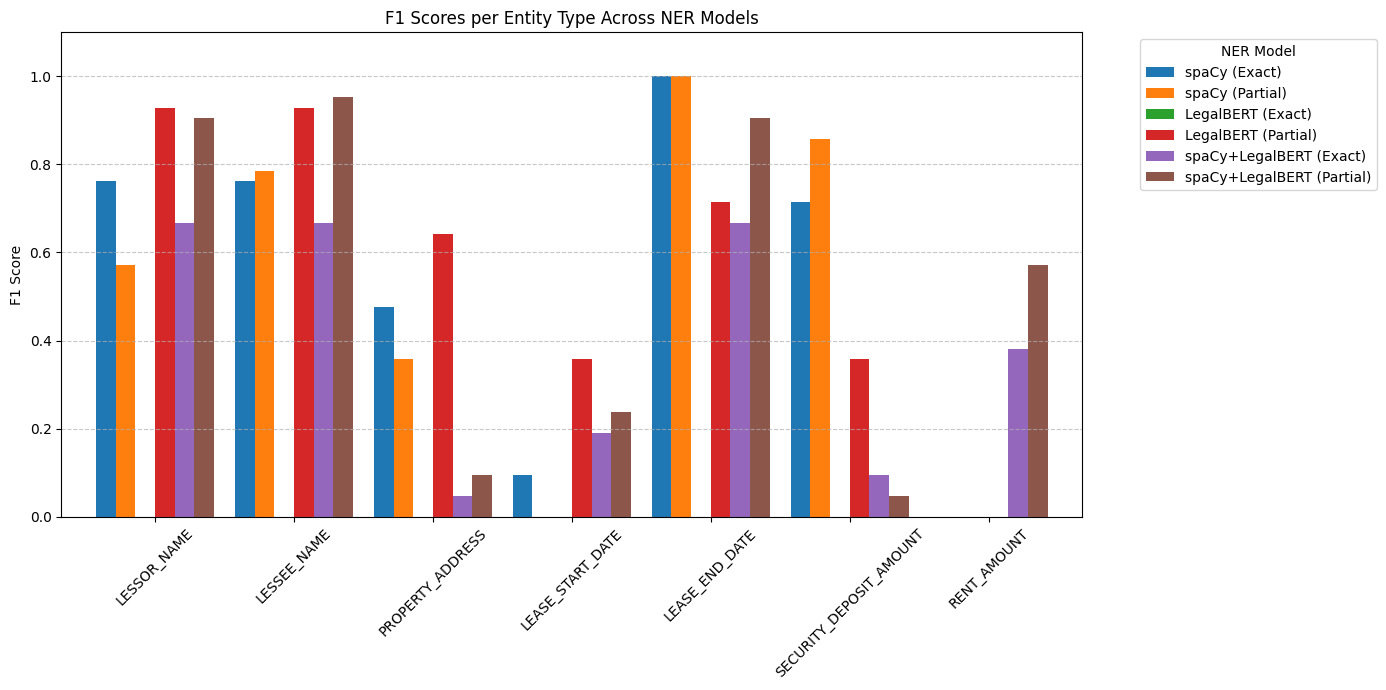

In [13]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd

# File mapping
file_paths = {
    "spaCy (Exact)": "spacy/fine_tuned_spacy_evaluation_results.json",
    "spaCy (Partial)": "spacy/fine_tuned_spacy_partial_result.json",
    "LegalBERT (Exact)": "legalBert/bert_exact.json",
    "LegalBERT (Partial)": "legalBert/bert_partial.json",
    "spaCy+LegalBERT (Exact)": "spacy_legalBert/spacy_bert_exact.json",
    "spaCy+LegalBERT (Partial)": "spacy_legalBert/spacy_bert_partial.json"
}

def load_f1_scores(files):
    entity_scores = {}
    for model_name, filename in files.items():
        if not os.path.exists(filename):
            print(f"File not found: {filename}")
            continue
        with open(filename, 'r') as f:
            data = json.load(f)
        for entity, metrics in data.items():
            f1 = metrics.get("f1_score", 0)
            if entity not in entity_scores:
                entity_scores[entity] = {}
            entity_scores[entity][model_name] = f1
    return pd.DataFrame(entity_scores).T.fillna(0)

def plot_f1_scores(df):
    fig, ax = plt.subplots(figsize=(14, 7))
    df.plot(kind="bar", width=0.85, ax=ax)
    ax.set_title("F1 Scores per Entity Type Across NER Models")
    ax.set_ylabel("F1 Score")
    ax.set_ylim(0, 1.1)
    ax.set_xticklabels(df.index, rotation=45)
    ax.legend(title="NER Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    filename = "f1_per_entity.png"
    fig.savefig(filename, dpi=300)
    print(f"✅ Saved plot to {filename}")
    plt.show()
    plt.close(fig)

if __name__ == "__main__":
    f1_df = load_f1_scores(file_paths)
    print("F1 Score Data:\n", f1_df)
    plot_f1_scores(f1_df)
